In [18]:
!rm -rf outputs
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default

/Users/agrigoryev/mambaforge/envs/downscaling/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63051 instead
  warnings.warn(


In [1]:
import pandas as pd
from TopoPyScale import topoclass as tc
from matplotlib import pyplot as plt
import TopoPyScale

ModuleNotFoundError: No module named 'pandas'

In [3]:
def compute_dem_param(dem_file, fname='ds_param.nc', project_directory='./'):
    """
    Function to compute and derive DEM parameters: slope, aspect, sky view factor

    Args:
        dem_file (str): path to raster file (geotif). Raster must be in local cartesian coordinate system (e.g. UTM)

    Returns:  
        dataset: x, y, elev, slope, aspect, svf

    """
    print('\n---> Extracting DEM parameters (slope, aspect, svf)')
    ds = xr.open_rasterio(dem_file).to_dataset('band')
    ds = ds.rename({1: 'elevation'})
    dx = ds.x.diff('x').median().values
    dy = ds.y.diff('y').median().values
    dem_arr = ds.elevation.values
    print('Computing slope and aspect ...')
    slope, aspect = gradient.gradient_d8(dem_arr, dx, dy)
    print('Computing svf ...')
    svf = viewf.viewf(np.double(dem_arr), dx)[0]

    ds['slope'] = (["y", "x"], slope)
    ds['aspect'] = (["y", "x"], np.deg2rad(aspect))
    ds['aspect_cos'] = (["y", "x"], np.cos(np.deg2rad(aspect)))
    ds['aspect_sin'] = (["y", "x"], np.sin(np.deg2rad(aspect)))
    ds['svf'] = (["y", "x"], svf)
    ds.attrs = dict(description="DEM input parameters to TopoSub",
                   author="TopoPyScale, https://github.com/ArcticSnow/TopoPyScale")
    ds.x.attrs = {'units': 'm'}
    ds.y.attrs = {'units': 'm'}
    ds.elevation.attrs = {'units': 'm'}
    ds.slope.attrs = {'units': 'rad'}
    ds.aspect.attrs = {'units': 'rad'}
    ds.aspect_cos.attrs = {'units': 'cosinus'}
    ds.aspect_sin.attrs = {'units': 'sinus'}
    ds.svf.attrs = {'units': 'ratio', 'standard_name': 'svf', 'long_name': 'Sky view factor'}
    te.to_netcdf(ds, fname=f'{project_directory}outputs/{fname}')

    return ds

In [1]:
import xarray as xr
import numpy as np
import rioxarray
from topocalc import gradient
from topocalc import viewf


dem_file = "inputs/dem/world_dem.tif"
ds = xr.open_dataset(dem_file, engine="rasterio", band_as_variable=True, chunks={'x': 1000, 'y': 1000})
ds = ds.rename({'band_1': 'elevation'})

dx = ds.x.diff('x').median().values
dy = ds.y.diff('y').median().values

ds.elevation.dtype

svf = viewf.viewf(np.double(ds.elevation), dx)[0]

#print('Computing slope and aspect ...')
#slope, aspect = gradient.gradient_d8(ds.elevation, dx, dy)
# ds['slope'] = (["y", "x"], slope)
# ds['aspect'] = (["y", "x"], np.deg2rad(aspect))
# ds['aspect_cos'] = (["y", "x"], np.cos(np.deg2rad(aspect)))
# ds['aspect_sin'] = (["y", "x"], np.sin(np.deg2rad(aspect)))


/Users/agrigoryev/mambaforge/envs/downscaling/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

In [9]:
ds.elevation.dtype 

dtype('float32')

In [3]:
# ========= STEP 1 ==========
# Load Configuration
config_file = './config.yml'
mp = tc.Topoclass(config_file)

---> no FSM directory to clean
---> no ensemble directory to clean

---> DEM file found
{'latN': 90.0, 'latS': -89.99999999300005, 'lonW': -180.0, 'lonE': 179.9999999860001}
Project lat/lon extent:

	------------------------------
	|        North:90.0          |
	|West:-180.0          East:180.0|
	|        South:-90.0          |
	------------------------------


---> Loading ERA5 surf climate forcing
Start =  2018-Jan
End =  2018-Jan
ECWMF SURF data found:
0    SURF_201801.nc
Name: target_file, dtype: object


---> Loading ERA5 plev climate forcing
Start =  2018-Jan
End =  2018-Jan
ECWMF PLEV data found:
0    PLEV_201801.nc
Name: target_file, dtype: object


In [4]:
%%time
# ======== STEP 2 ===========
# Compute parameters of the DEM (slope, aspect, sky view factor)
mp.compute_dem_param()



---> Extracting DEM parameters (slope, aspect, svf)
Computing slope and aspect ...
Computing svf ...


: 

: 

In [5]:
%%time
mp.extract_topo_param()

---> Scaling data prior to clustering
Index(['y', 'x', 'elevation', 'slope', 'aspect', 'aspect_cos', 'aspect_sin',
       'svf'],
      dtype='object')
---> Clustering with Mini-Batch K-means in 10 clusters
---> Mini-Batch Kmean finished in 0.0s
---> File ./outputs/ds_param.nc saved
---> Centroids file df_centroids.pck saved
CPU times: user 1.55 s, sys: 1.58 s, total: 3.13 s
Wall time: 519 ms


In [6]:
%%time
# ========= STEP 3 ==========
# compute solar geometry and horizon angles
mp.compute_solar_geometry()
mp.compute_horizon()



---> Computing solar geometry
---> File ./outputs/ds_solar.nc saved

---> Computing horizons with 10 degree increments
---> File ./outputs/da_horizon.nc saved
---> Centroids file df_centroids.pck updated with horizons
CPU times: user 4.25 s, sys: 882 ms, total: 5.14 s
Wall time: 4.48 s


In [7]:
%%time
# ========= STEP 4 ==========
# Perform the downscaling
mp.downscale_climate()


---> Downscaling climate to list of points using TopoScale
./outputs/tmp cleaned
No ERA5T  PRESSURE data present with additional dimension <expver>
No ERA5T SURFACE data present with additional dimension <expver>
Downscaling t,q,u,v,tp,p for point: 1 out of 10
---> WARNING: Point 0 is -260.0 m lower than the 1000hPa geopotential
=> Values sampled from Psurf and lowest Plevel. No vertical interpolation
Downscaling t,q,u,v,tp,p for point: 2 out of 10
---> WARNING: Point 1 is -121.0 m lower than the 1000hPa geopotential
=> Values sampled from Psurf and lowest Plevel. No vertical interpolation
Downscaling t,q,u,v,tp,p for point: 3 out of 10
---> WARNING: Point 2 is -43.0 m lower than the 1000hPa geopotential
=> Values sampled from Psurf and lowest Plevel. No vertical interpolation
Downscaling t,q,u,v,tp,p for point: 4 out of 10
---> WARNING: Point 3 is -260.0 m lower than the 1000hPa geopotential
=> Values sampled from Psurf and lowest Plevel. No vertical interpolation
Downscaling t,q,u,v

In [8]:
%time
import xarray
# ========= STEP 6 ==========
# Export output to desired format
mp.to_netcdf(variables=["t","tp"])
ds = xarray.open_dataset('outputs/output.nc')
ds

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
---> File ./outputs/output.nc saved
---> File output.nc saved


<xarray.Dataset>
Dimensions:         (point_id: 10, time: 744)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:00:00
  * point_id        (point_id) int64 0 1 2 3 4 5 6 7 8 9
    reference_time  datetime64[ns] ...
Data variables:
    t               (point_id, time) float64 ...
    tp              (point_id, time) float64 ...

In [9]:
mp.downscaled_pts

<xarray.Dataset>
Dimensions:           (time: 744, point_id: 10)
Coordinates:
  * time              (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:00:00
  * point_id          (point_id) int64 0 1 2 3 4 5 6 7 8 9
    reference_time    datetime64[ns] 2018-01-01
Data variables: (12/16)
    t                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    u                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    v                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    q                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    tp                (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    p                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    ...                ...
    cse               (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    LW                (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    SW_diffuse        (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    cos_illumination  (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    SW_direct         (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    SW                (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>

In [10]:
mp.downscaled_pts


<xarray.Dataset>
Dimensions:           (time: 744, point_id: 10)
Coordinates:
  * time              (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:00:00
  * point_id          (point_id) int64 0 1 2 3 4 5 6 7 8 9
    reference_time    datetime64[ns] 2018-01-01
Data variables: (12/16)
    t                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    u                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    v                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    q                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    tp                (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    p                 (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    ...                ...
    cse               (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    LW                (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    SW_diffuse        (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    cos_illumination  (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    SW_direct         (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>
    SW                (point_id, time) float64 dask.array<chunksize=(1, 744), meta=np.ndarray>

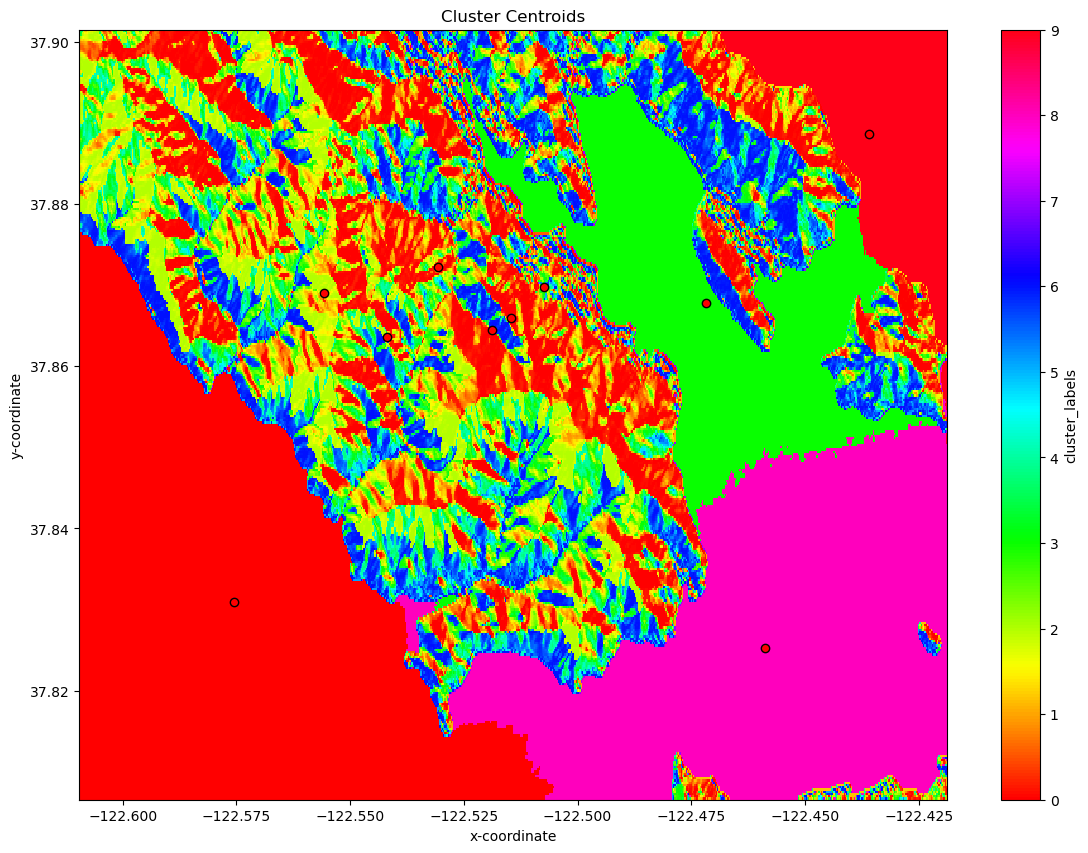

In [11]:
mp.toposub.plot_clusters_map()

In [12]:
xarray.open_dataset("outputs/da_horizon.nc")

<xarray.Dataset>
Dimensions:  (azimuth: 36, y: 342, x: 687)
Coordinates:
  * y        (y) float64 37.9 37.9 37.9 37.9 37.9 ... 37.81 37.81 37.81 37.81
  * x        (x) float64 -122.6 -122.6 -122.6 -122.6 ... -122.4 -122.4 -122.4
  * azimuth  (azimuth) float64 -175.0 -165.0 -155.0 -145.0 ... 155.0 165.0 175.0
Data variables:
    horizon  (azimuth, y, x) float64 ...

In [13]:
xarray.open_dataset("outputs/ds_solar.nc")

<xarray.Dataset>
Dimensions:         (point_id: 10, time: 744)
Coordinates:
  * point_id        (point_id) int64 0 1 2 3 4 5 6 7 8 9
  * time            (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:00:00
    reference_time  datetime64[ns] ...
Data variables:
    zenith          (point_id, time) float64 ...
    azimuth         (point_id, time) float64 ...
    elevation       (point_id, time) float64 ...
    mu0             (point_id, time) float64 ...
    SWtoa           (point_id, time) float64 ...
    sunset          (point_id, time) float64 ...

In [14]:
mp.toposub.df_centroids

,y,x,elevation,slope,aspect,aspect_cos,aspect_sin,svf,point_id,longitude,...,hori_azi_85.0,hori_azi_95.0,hori_azi_105.0,hori_azi_115.0,hori_azi_125.0,hori_azi_135.0,hori_azi_145.0,hori_azi_155.0,hori_azi_165.0,hori_azi_175.0
0,37.830877,-122.575486,0.000051,6.751266e-13,3.141593,-1.000000,1.672447e-14,0.603071,0,-122.575486,...,1.570363,1.570463,1.570641,1.570618,1.570615,1.570641,1.570667,1.570629,1.570605,1.570605
1,37.872315,-122.530622,138.992525,1.570743e+00,2.431561,-0.681461,5.784314e-01,0.201501,1,-122.530622,...,1.570556,1.570538,1.570562,1.570345,0.000000,0.000000,0.000000,0.000000,0.000000,1.570495
2,37.868997,-122.555780,217.236562,1.570643e+00,5.203844,0.386345,-6.420414e-01,0.275608,2,-122.555780,...,1.570770,1.570770,1.570768,1.570768,1.570775,1.570772,1.570775,1.570777,1.570769,1.570765
3,37.867786,-122.471750,0.419332,5.599284e-02,3.134532,-0.998891,6.938222e-03,0.113396,3,-122.471750,...,1.570679,1.570710,1.570731,1.570738,1.570742,1.570743,1.570734,1.570728,1.570710,1.570684
4,37.864447,-122.518768,75.164650,1.570695e+00,3.884598,-0.648305,-5.880477e-01,0.068414,4,-122.518768,...,1.570741,1.570743,1.570749,1.570755,1.570761,1.570760,1.570755,1.570751,1.570743,1.570743
5,37.863671,-122.541972,174.474974,1.570750e+00,0.512010,0.809561,4.474661e-01,0.237118,5,-122.541972,...,1.570517,1.570517,1.570509,1.570745,1.570740,1.570731,1.570759,1.570762,1.570764,1.570765
6,37.865961,-122.514697,59.404166,1.570699e+00,5.652445,0.750436,-5.449034e-01,0.138288,6,-122.514697,...,1.568008,0.000000,1.568951,1.570180,1.519975,0.000000,0.000000,0.000000,0.000000,0.000000
7,37.869733,-122.507451,37.941221,1.570648e+00,1.138677,0.339375,7.163554e-01,0.086414,7,-122.507451,...,1.570753,1.570753,1.570755,1.570753,1.570748,1.570740,1.570748,1.570720,1.570755,1.570517
8,37.825197,-122.458724,0.227412,3.045400e-02,3.137594,-0.997950,3.606842e-03,0.341240,8,-122.458724,...,0.000000,1.568158,0.000000,0.000000,1.566784,1.570416,1.570570,1.570137,1.569532,1.570435
9,37.888658,-122.435944,3.712199,1.691714e-01,3.114617,-0.990393,2.506540e-02,0.586669,9,-122.435944,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


[284 285 283 285 285 283 285 285 285 285]
[[283 283 283 ... 285 285 285]
 [283 283 283 ... 285 285 285]
 [283 283 283 ... 285 285 285]
 ...
 [284 284 284 ... 285 285 285]
 [284 284 284 ... 285 285 285]
 [284 284 284 ... 285 285 285]]


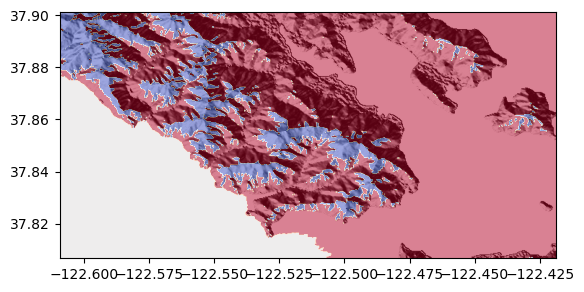

In [15]:
mp.plot.map_variable(colorbar=False,cmap=plt.cm.coolwarm)

In [16]:
mp.downscaled_pts['t'][0]

<xarray.DataArray 't' (time: 744)>
dask.array<getitem, shape=(744,), dtype=float64, chunksize=(744,), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:00:00
    point_id        int64 0
    reference_time  datetime64[ns] 2018-01-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [17]:
for i,value in enumerate(mp.downscaled_pts['t']):
    print(int(mp.downscaled_pts['t'][i][0].values))

284
285
283
285
285
283
285
285
285
285
